# Bayesian Anomaly Detection - Example

## Introduction to Bayesian Anomaly Detection

Bayesian anomaly detection provides a principled statistical framework for identifying and mitigating outliers in scientific data analysis. This approach is particularly valuable when dealing with contaminated datasets where traditional methods may fail catastrophically.

### Key References
- **Paper**: [Bayesian approach to radio frequency interference mitigation](https://arxiv.org/abs/2211.15448) - Leeney et al. (2022)
- **Enhanced Method**: [Enhanced Bayesian RFI Mitigation and Transient Flagging Using Likelihood Reweighting](https://arxiv.org/abs/2310.02146) - Anstey and Leeney (2023)
- **Presentation**: [JAX Bandflux Talk](https://github.com/samleeney/Talks/blob/eucaifcon2025/jax_bandflux_talk.pdf) - EucAIFCon 2025

### Problem Statement
Traditional likelihood-based inference assumes all data points are drawn from the same underlying model. However, real datasets often contain:
- Instrumental artefacts
- Systematic errors  
- Radio frequency interference
- Cosmic ray hits
- Other contaminating signals

These anomalies can severely bias parameter estimates and inflate uncertainties.

### Mathematical Framework

The Bayesian anomaly detection method introduces a **binary anomaly mask** $\varepsilon_i$ for each data point:

$$\varepsilon_i = \begin{cases}
0 & \text{if data point } i \text{ is expected} \\
1 & \text{if data point } i \text{ is anomalous}
\end{cases}$$

Each mask element follows a **Bernoulli prior distribution**:
$$P(\varepsilon_i) = p^{\varepsilon_i} (1-p)^{1-\varepsilon_i}$$

where $p$ is the prior probability that any given data point is anomalous.

The **piecewise likelihood** combines normal and anomalous cases:
$$P(D, \varepsilon | \theta) = \prod_{i=1}^N \left[ \mathcal{L}_i(\theta)(1-p) \right]^{1-\varepsilon_i} \left[ \frac{p}{\Delta} \right]^{\varepsilon_i}$$

where:
- $\mathcal{L}_i(\theta)$ is the standard likelihood for data point $i$
- $\Delta$ is a normalisation constant (data range scale)
- Anomalous points contribute a flat likelihood $p/\Delta$

**Marginalising** over all possible anomaly configurations:
$$P(D | \theta) = \sum_{\varepsilon \in \{0,1\}^N} P(D, \varepsilon | \theta)$$

However, computing this sum over all $2^N$ possible mask combinations is computationally intractable for realistic datasets. Instead, we assume that **the correct anomaly mask is the most likely one** for any given set of parameters $\theta$. This assumption transforms the marginalisation into a simple maximisation over masks, making the method computationally efficient whilst preserving the key benefits of the Bayesian approach.

This leads to the **anomaly-corrected log-likelihood**:
$$\log P(D|\theta) = \sum_{i=1}^N \begin{cases}
\log \mathcal{L}_i + \log(1-p) & \text{if } \log \mathcal{L}_i + \log(1-p) > \log p - \log \Delta \\
\log p - \log \Delta & \text{otherwise}
\end{cases}$$

**Note**: For large datasets with many potential anomalies, enhanced computational methods using likelihood reweighting can provide significant performance improvements (see Anstey and Leeney 2023 for details on achieving ~25× speedup for datasets with thousands of time bins).

---

This demonstration shows how to integrate anomaly detection into a Bayesian data analysis pipeline using a simple linear regression example with artificial outliers.

## Generate Mock Data

First, generate some mock data.

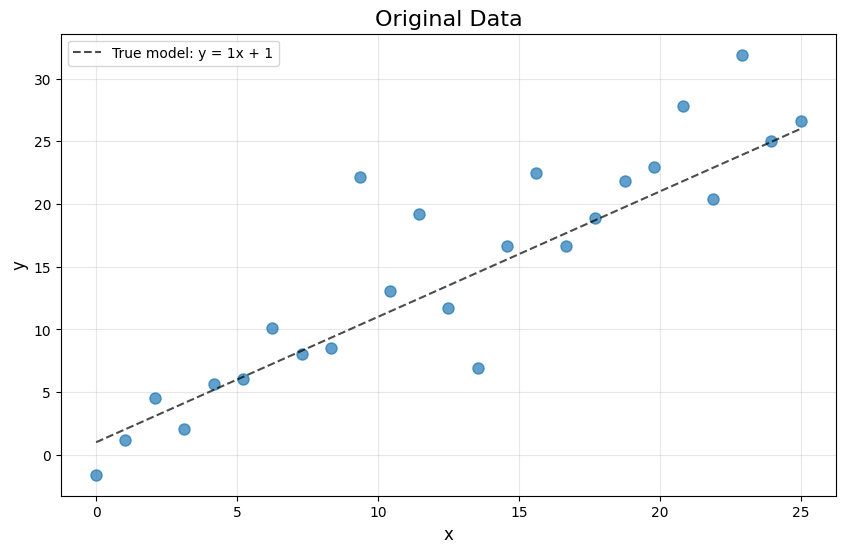

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 25
x = np.linspace(0, 25, N)
m = 1
c = 1
sig = 5
y = m * x + c + np.random.randn(N) * sig

plt.figure(figsize=(10, 6))
plt.plot(x, y, "o", markersize=8, alpha=0.7)
plt.plot(x, m * x + c, 'k--', alpha=0.7, label=f'True model: y = {m}x + {c}')
plt.title("Original Data", fontsize=16)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Add Anomalies

Add some anomalies to the data

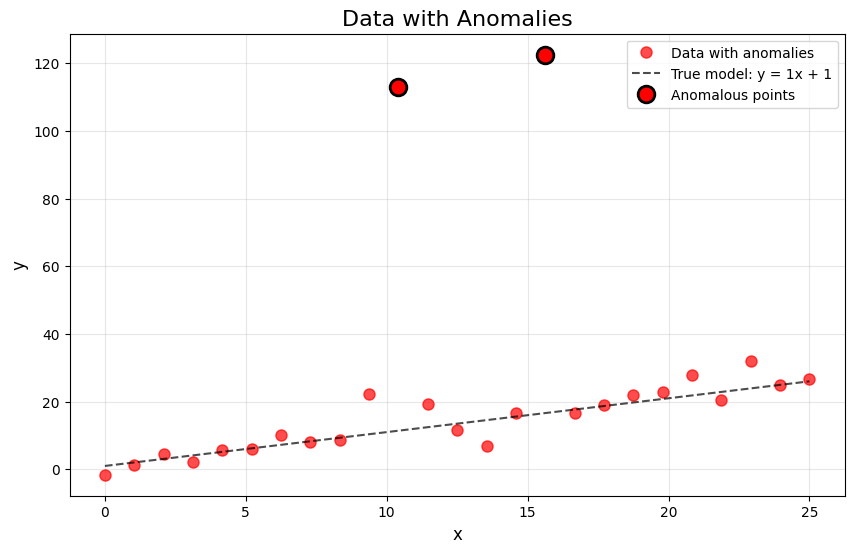

In [2]:
y[10] += 100
y[15] += 100

plt.figure(figsize=(10, 6))
plt.plot(x, y, "ro", markersize=8, alpha=0.7, label='Data with anomalies')
plt.plot(x, m * x + c, 'k--', alpha=0.7, label=f'True model: y = {m}x + {c}')

# Highlight the anomalous points
plt.plot(x[10], y[10], 'ro', markersize=12, markeredgecolor='black', 
         markeredgewidth=2, label='Anomalous points')
plt.plot(x[15], y[15], 'ro', markersize=12, markeredgecolor='black', 
         markeredgewidth=2)

plt.title("Data with Anomalies", fontsize=16)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Define Likelihood Functions

Now, define a traditional likelihood function and fit the data without modeling the anomalies.

In [3]:
def likelihood(theta):
    m = theta[0]
    c = theta[1]
    sig = theta[2]
    y_ = m * x + c
    return (-((y_ - y) ** 2) / sig**2 / 2 - np.log(2 * np.pi * sig**2) / 2).sum()

Now, we'll define a likelihood function that can correct for anomalies.
Note the difference between the two likelihoods. Notice the condition imposed on the likelihood by `emax'.

In [4]:
def anomaly_corrected_likelihood(theta):
    m = theta[0]
    c = theta[1]
    sig = theta[2]
    logp = theta[3]  # logp is now a free parameter
    p = np.exp(logp)
    y_ = m * x + c
    logL = (
        -((y_ - y) ** 2) / sig**2 / 2 - np.log(2 * np.pi * sig**2) / 2 + np.log(1 - p)
    )
    emax = logL > logp - np.log(delta)
    logPmax = np.where(emax, logL, logp - np.log(delta)).sum()
    return logPmax

## Define Prior and Parameters

Define a prior. Notice that the prior range which encapsulates the full range of possible values from the data as defined by delta.

In [5]:
def uniform_prior(a, b):
    """Simple uniform prior function"""
    def prior_func(u):
        return a + (b - a) * u
    return prior_func

def prior(hypercube):
    theta = np.zeros_like(hypercube)
    theta[0] = uniform_prior(
        -delta / (np.max(x) - np.min(x)), delta / (np.max(x) - np.min(x))
    )(hypercube[1])  # m
    theta[1] = uniform_prior(-delta, delta)(hypercube[0])  # c
    theta[2] = uniform_prior(0, delta)(hypercube[2])  # sig
    theta[3] = uniform_prior(-10, -0.1)(hypercube[3])  # logp with prior from -10 to -0.1
    return theta

Set $p$ (the probability thresholding term) and $\Delta$ (the length scale in units of data)

In [6]:
delta = np.max(y)
# logp will now be a free parameter sampled from the prior

## Fit model with basic sampler

Implement a basic Metropolis-Hastings MCMC sampler that doesn't require any external packages. We use basic MCMC for the demonstration, but note that any numerical sampling procedure would work here. We reccomend GPU optimised Nested Sampling [https://handley-lab.co.uk/nested-sampling-book/intro.html] for more complex problems.

In [7]:
def simple_mcmc(log_likelihood, prior_func, n_samples=10000, n_burn=1000, step_size=0.1):
    """
    Simple Metropolis-Hastings MCMC sampler
    
    Parameters:
    -----------
    log_likelihood : function
        Function that takes parameters and returns log likelihood
    prior_func : function
        Function that transforms from unit hypercube to parameter space
    n_samples : int
        Number of samples to draw
    n_burn : int
        Number of burn-in samples
    step_size : float
        Step size for proposal distribution
    
    Returns:
    --------
    samples : array
        MCMC samples
    """
    # Initialize - now 4 dimensions to include logp
    n_dims = 4
    samples = np.zeros((n_samples, n_dims))
    
    # Start from center of unit hypercube
    current_hypercube = np.array([0.5, 0.5, 0.5, 0.5])
    current_params = prior_func(current_hypercube)
    current_logL = log_likelihood(current_params)
    
    n_accepted = 0
    
    for i in range(n_samples + n_burn):
        # Propose new state
        proposal_hypercube = current_hypercube + np.random.normal(0, step_size, n_dims)
        
        # Reflect at boundaries to stay in [0,1]
        proposal_hypercube = np.clip(proposal_hypercube, 0, 1)
        
        proposal_params = prior_func(proposal_hypercube)
        proposal_logL = log_likelihood(proposal_params)
        
        # Accept/reject
        log_alpha = proposal_logL - current_logL
        if np.log(np.random.rand()) < log_alpha:
            current_hypercube = proposal_hypercube
            current_params = proposal_params
            current_logL = proposal_logL
            n_accepted += 1
        
        # Store sample after burn-in
        if i >= n_burn:
            samples[i - n_burn] = current_params
    
    acceptance_rate = n_accepted / (n_samples + n_burn)
    print(f"Acceptance rate: {acceptance_rate:.3f}")
    
    return samples

## Fit with Traditional Likelihood

We first fit the data using the traditional likelihood

In [8]:
print("Fitting with traditional likelihood...")
samples_no_correction = simple_mcmc(likelihood, prior, n_samples=5000)

Fitting with traditional likelihood...
Acceptance rate: 0.106


/tmp/ipykernel_316251/3102404388.py:6: RuntimeWarning: divide by zero encountered in divide
  return (-((y_ - y) ** 2) / sig**2 / 2 - np.log(2 * np.pi * sig**2) / 2).sum()
/tmp/ipykernel_316251/3102404388.py:6: RuntimeWarning: divide by zero encountered in log
  return (-((y_ - y) ** 2) / sig**2 / 2 - np.log(2 * np.pi * sig**2) / 2).sum()
/tmp/ipykernel_316251/3102404388.py:6: RuntimeWarning: invalid value encountered in subtract
  return (-((y_ - y) ** 2) / sig**2 / 2 - np.log(2 * np.pi * sig**2) / 2).sum()


## Fit with Anomaly-Corrected Likelihood

Fit the data, this time using the correcting likelihood

In [9]:
print("Fitting with anomaly-corrected likelihood...")
samples_corrected = simple_mcmc(anomaly_corrected_likelihood, prior, n_samples=5000)

Fitting with anomaly-corrected likelihood...


/tmp/ipykernel_316251/2134811479.py:9: RuntimeWarning: divide by zero encountered in divide
  -((y_ - y) ** 2) / sig**2 / 2 - np.log(2 * np.pi * sig**2) / 2 + np.log(1 - p)
/tmp/ipykernel_316251/2134811479.py:9: RuntimeWarning: divide by zero encountered in log
  -((y_ - y) ** 2) / sig**2 / 2 - np.log(2 * np.pi * sig**2) / 2 + np.log(1 - p)
/tmp/ipykernel_316251/2134811479.py:9: RuntimeWarning: invalid value encountered in subtract
  -((y_ - y) ** 2) / sig**2 / 2 - np.log(2 * np.pi * sig**2) / 2 + np.log(1 - p)


Acceptance rate: 0.003


## Compare Results

Plot and compare the results from both approaches

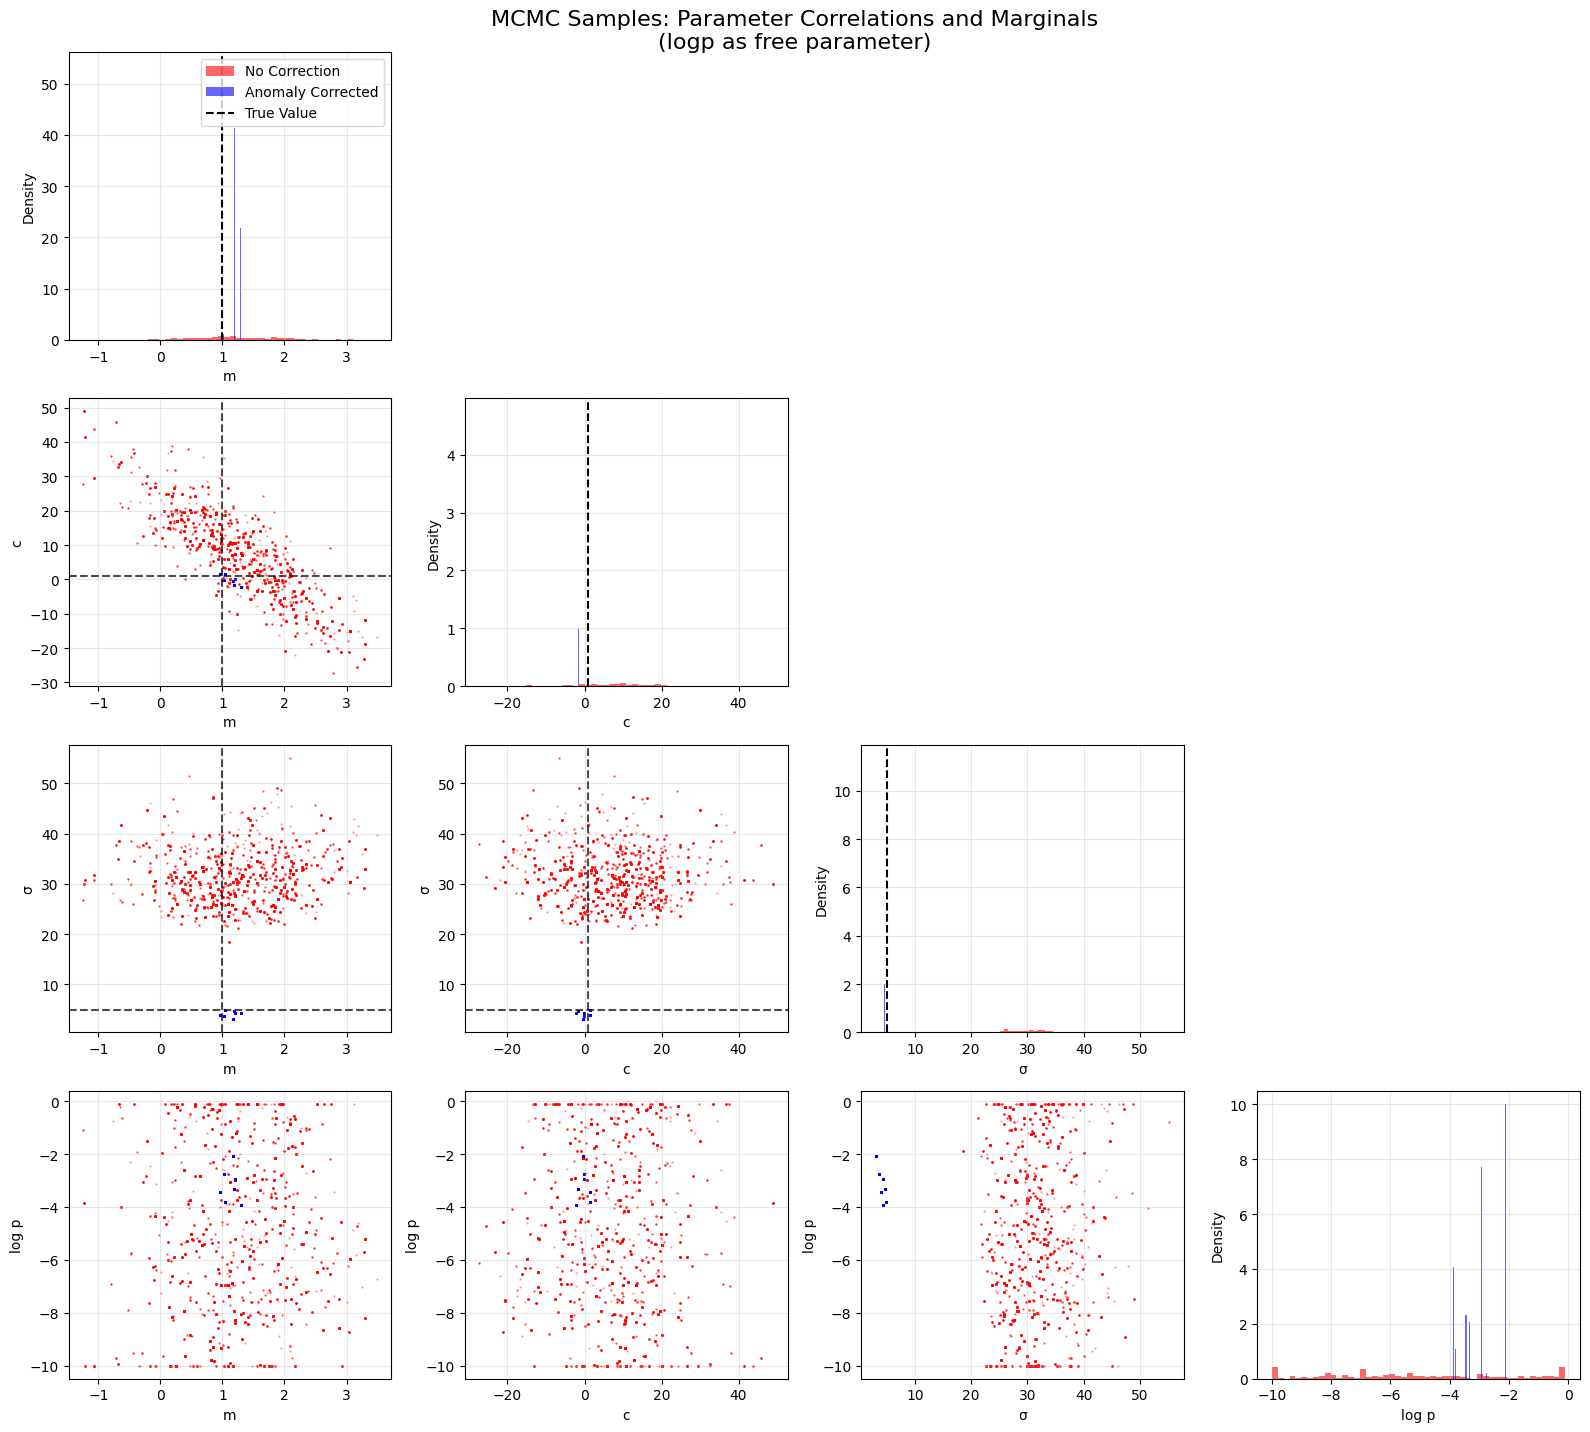

In [10]:
# Create corner plot
fig, axes = plt.subplots(4, 4, figsize=(16, 14))
param_names = ['m', 'c', 'σ', 'log p']
true_values = [1, 1, 5, -2.5]  # True parameter values including logp

for i in range(4):
    for j in range(4):
        ax = axes[i, j]
        
        if i == j:
            # Diagonal: 1D histograms
            ax.hist(samples_no_correction[:, i], bins=50, alpha=0.6, 
                   label='No Correction', density=True, color='red')
            ax.hist(samples_corrected[:, i], bins=50, alpha=0.6, 
                   label='Anomaly Corrected', density=True, color='blue')
            if i < 3:  # Only show true value line for m, c, σ (not for logp since it wasn't fixed before)
                ax.axvline(true_values[i], color='black', linestyle='--', label='True Value')
            ax.set_xlabel(param_names[i])
            ax.set_ylabel('Density')
            ax.grid(True, alpha=0.3)
            if i == 0:
                ax.legend()
                
        elif i > j:
            # Lower triangle: 2D scatter plots
            ax.scatter(samples_no_correction[:, j], samples_no_correction[:, i], 
                      alpha=0.3, s=0.5, color='red', label='No Correction')
            ax.scatter(samples_corrected[:, j], samples_corrected[:, i], 
                      alpha=0.4, s=0.5, color='blue', label='Anomaly Corrected')
            if i < 3 and j < 3:  # Only show true value lines for original parameters
                ax.axhline(true_values[i], color='black', linestyle='--', alpha=0.7)
                ax.axvline(true_values[j], color='black', linestyle='--', alpha=0.7)
            ax.set_xlabel(param_names[j])
            ax.set_ylabel(param_names[i])
            ax.grid(True, alpha=0.3)
            
        else:
            # Upper triangle: remove
            ax.axis('off')

plt.tight_layout()
plt.suptitle('MCMC Samples: Parameter Correlations and Marginals\n(logp as free parameter)', 
             fontsize=16, y=1.02)
plt.show()

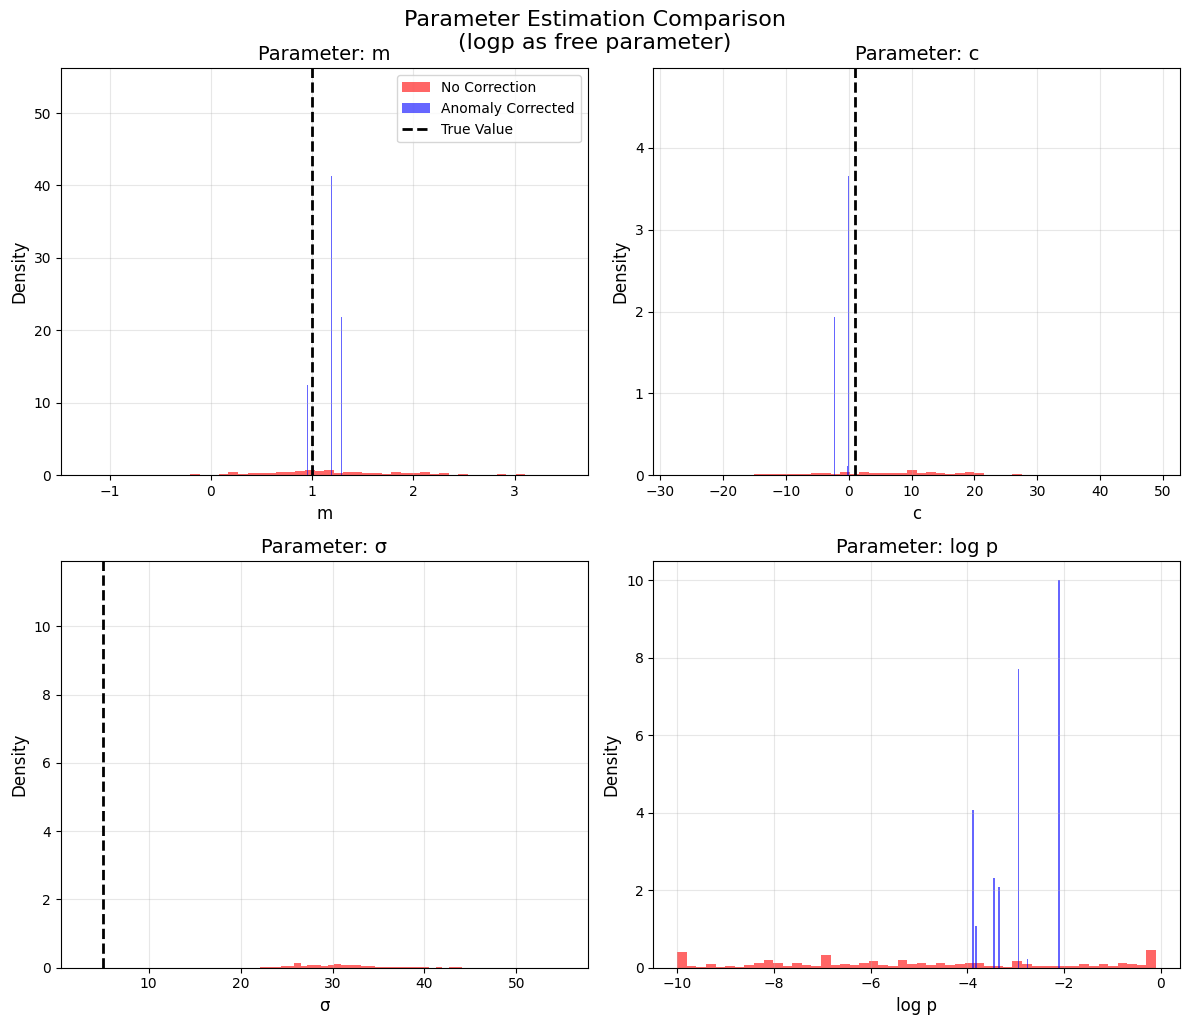

In [11]:
# Create a cleaner 2x2 comparison of parameter marginals
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(4):
    ax = axes[i]
    
    # Plot histograms
    ax.hist(samples_no_correction[:, i], bins=50, alpha=0.6, 
           label='No Correction', density=True, color='red')
    ax.hist(samples_corrected[:, i], bins=50, alpha=0.6, 
           label='Anomaly Corrected', density=True, color='blue')
    
    # Add true value line for first 3 parameters
    if i < 3:
        ax.axvline(true_values[i], color='black', linestyle='--', 
                  linewidth=2, label='True Value')
    
    ax.set_xlabel(param_names[i], fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title(f'Parameter: {param_names[i]}', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.suptitle('Parameter Estimation Comparison\n(logp as free parameter)', 
             fontsize=16, y=1.02)
plt.show()

## Summary Statistics

Compare the parameter estimates quantitatively

In [12]:
print("Parameter Estimation Summary:")
print("=" * 60)
print(f"{'Parameter':<10} {'True':<8} {'No Corr':<15} {'Corrected':<15}")
print("-" * 60)

for i, (name, true_val) in enumerate(zip(param_names, true_values)):
    no_corr_mean = np.mean(samples_no_correction[:, i])
    no_corr_std = np.std(samples_no_correction[:, i])
    corr_mean = np.mean(samples_corrected[:, i])
    corr_std = np.std(samples_corrected[:, i])
    
    if i < 3:  # For original parameters, show comparison to true value
        print(f"{name:<10} {true_val:<8.1f} {no_corr_mean:<7.2f}±{no_corr_std:<6.2f} {corr_mean:<7.2f}±{corr_std:<6.2f}")
    else:  # For logp, don't show "true" value since it's now free
        print(f"{name:<10} {'free':<8} {no_corr_mean:<7.2f}±{no_corr_std:<6.2f} {corr_mean:<7.2f}±{corr_std:<6.2f}")

Parameter Estimation Summary:
Parameter  True     No Corr         Corrected      
------------------------------------------------------------
m          1.0      1.24   ±0.81   1.17   ±0.09  
c          1.0      7.21   ±11.76  -0.44  ±1.07  
σ          5.0      30.78  ±4.88   3.90   ±0.67  
log p      free     -5.13  ±3.05   -2.88  ±0.68  


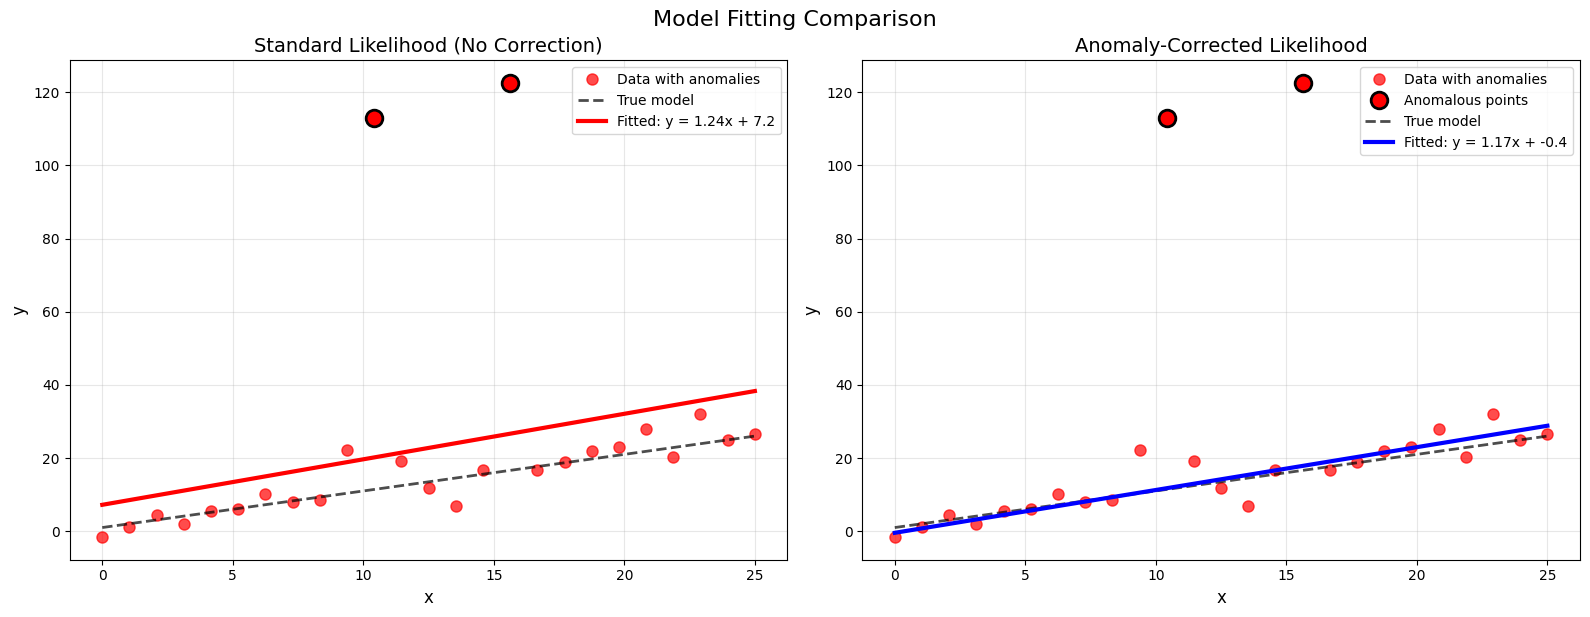

In [13]:
# Show fitted models comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Get parameter estimates
m_no_corr = np.mean(samples_no_correction[:, 0])
c_no_corr = np.mean(samples_no_correction[:, 1])
m_corr = np.mean(samples_corrected[:, 0])
c_corr = np.mean(samples_corrected[:, 1])

x_model = np.linspace(0, 25, 100)

# Plot 1: No correction
ax1.plot(x, y, "ro", markersize=8, alpha=0.7, label='Data with anomalies')
ax1.plot(x[10], y[10], 'ro', markersize=12, markeredgecolor='black', 
         markeredgewidth=2)
ax1.plot(x[15], y[15], 'ro', markersize=12, markeredgecolor='black', 
         markeredgewidth=2)
ax1.plot(x_model, m * x_model + c, 'k--', alpha=0.7, linewidth=2, label='True model')
ax1.plot(x_model, m_no_corr * x_model + c_no_corr, 'r-', linewidth=3, 
         label=f'Fitted: y = {m_no_corr:.2f}x + {c_no_corr:.1f}')
ax1.set_title("Standard Likelihood (No Correction)", fontsize=14)
ax1.set_xlabel("x", fontsize=12)
ax1.set_ylabel("y", fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Anomaly corrected
ax2.plot(x, y, "ro", markersize=8, alpha=0.7, label='Data with anomalies')
ax2.plot(x[10], y[10], 'ro', markersize=12, markeredgecolor='black', 
         markeredgewidth=2, label='Anomalous points')
ax2.plot(x[15], y[15], 'ro', markersize=12, markeredgecolor='black', 
         markeredgewidth=2)
ax2.plot(x_model, m * x_model + c, 'k--', alpha=0.7, linewidth=2, label='True model')
ax2.plot(x_model, m_corr * x_model + c_corr, 'b-', linewidth=3, 
         label=f'Fitted: y = {m_corr:.2f}x + {c_corr:.1f}')
ax2.set_title("Anomaly-Corrected Likelihood", fontsize=14)
ax2.set_xlabel("x", fontsize=12)
ax2.set_ylabel("y", fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Model Fitting Comparison', fontsize=16, y=1.02)
plt.show()

## Key Point

The vast majority of this example makes up the general 'pipeline' for simulating and analysing the data. Only three lines of code are modified (inside `anomaly_corrected_likelihood`) to implement the anomaly detection correction.

Notice that σ is estimated completely wrong in the uncorrected case, and the confidence in the other parameters is low. The anomaly detection approach provides much more accurate parameter estimates.